## ERA Session7 Assignment: Model4
### Target
 - Reduce the number of parameters from 17k to 8k
 - Instead of going for kernel number from 16 > 32, approach is to change to 10 > 16
 - Add Gap layer to collapse image quickly while reducing the number of params

### Results
 - No. of Params: 8480
 - Best Test Accuracy: 99.34%
 - Best Train Accuracy: 99.06%

### Analysis
 - Number of parametrs reduced from 17584 to 8480
 - Gap layer helped to reduce the number of params by a great margin
 - Reducing the number of kernels helped too, still the params count is little higher than expected < 8k params
 - Accuracies have dipped a bit as a result of reduced number of params


In [28]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [29]:
from models import Model4 as Model

In [30]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                    #    transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [31]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [32]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [33]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Model().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [34]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
  epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [35]:
model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.09676503390073776 Batch_id=468 Accuracy=87.95: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]



Test set: Average loss: 0.0921, Accuracy: 9752/10000 (97.52%)

EPOCH: 2


Loss=0.1601153016090393 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:19<00:00, 24.03it/s]



Test set: Average loss: 0.0535, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.03128966689109802 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0476, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.06024380028247833 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0372, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.048491377383470535 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s]



Test set: Average loss: 0.0323, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.04235617443919182 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0330, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.03041934221982956 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]



Test set: Average loss: 0.0301, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.022090425714850426 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]



Test set: Average loss: 0.0306, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.04302377626299858 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:20<00:00, 23.30it/s]



Test set: Average loss: 0.0261, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.012361489236354828 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:20<00:00, 22.95it/s]



Test set: Average loss: 0.0285, Accuracy: 9907/10000 (99.07%)

EPOCH: 11


Loss=0.013840184547007084 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.036057282239198685 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]



Test set: Average loss: 0.0219, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.028474418446421623 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:18<00:00, 25.41it/s]



Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.1014789342880249 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:19<00:00, 23.65it/s]



Test set: Average loss: 0.0241, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.02936793863773346 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.52it/s]



Test set: Average loss: 0.0216, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

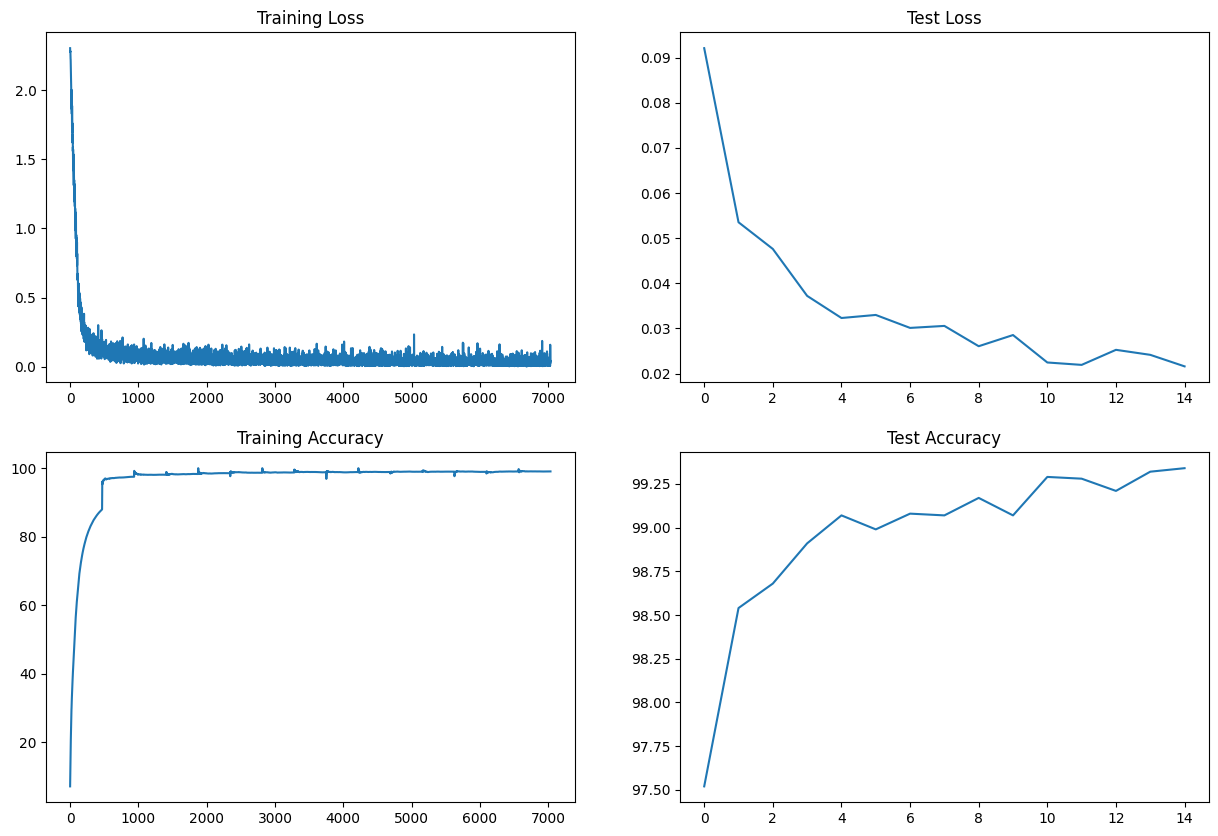

In [36]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")